# Extrapolating line game model to new teaching stimuli

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('talk')

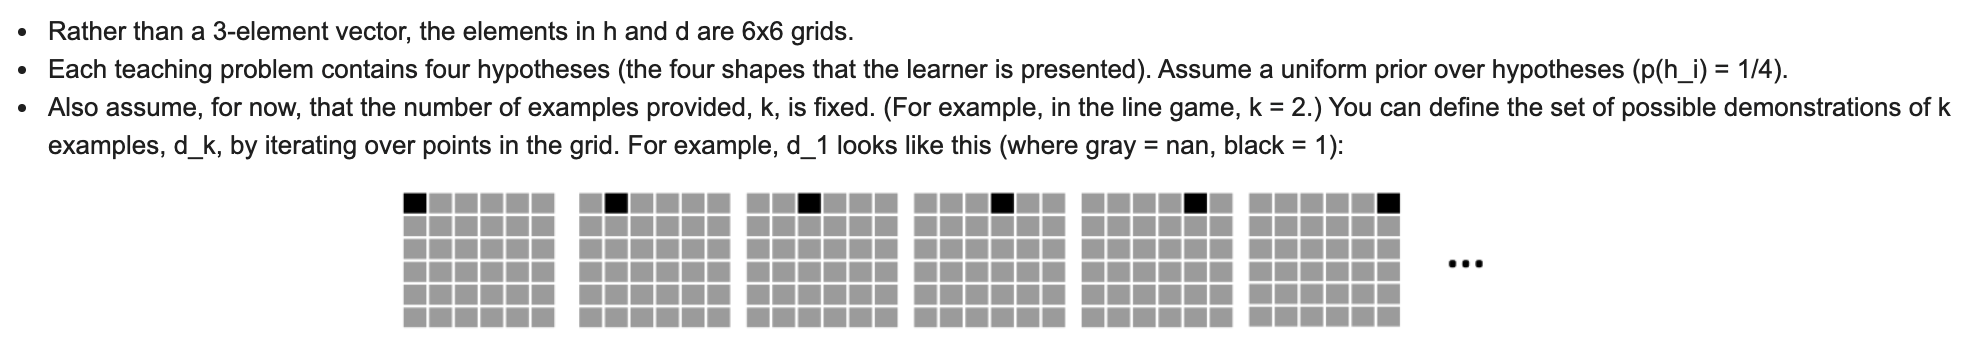

In [ ]:
# Import all problems from spreadsheet

from make_df import make_df_from_spreadsheet

filename = 'teaching_stimuli - all_examples.csv'
all_problems = make_df_from_spreadsheet(filename)

In [ ]:
def find_problem(index, all_problems):
    '''Return flat and non flat representations of a specific problem'''
    h = np.array([i for i in all_problems.loc[index,:].to_numpy(dtype=object)])
    h_flat = all_problems.loc[index,:].to_numpy(dtype=object) # Instead of 3d matrix, create an array of arrays
    #print(h.shape)
    #print(h_flat.shape)
    return h, h_flat

In [ ]:
h, h_flat = find_problem(34, all_problems)

## View problem

In [ ]:
def plot_problem(problem):
    fig, ax = plt.subplots(1,4, figsize = (16,4))
    opt_labels = ['$h_1$', '$h_2$', '$h_3$', '$h_4$']

    for idx,ax_i in enumerate(ax):
        hm = sns.heatmap(problem[idx,:,:], ax=ax_i,
                         cmap='gray_r', cbar=False,
                         linewidths=2, linecolor='#808080')
        ax_i.set(xticks=[], yticks=[], title=opt_labels[idx]) 

In [ ]:
plot_problem(h)

## Start with $k=1$

In [ ]:
# Get possible positive examples
# Don't need a mask here b/c we are already choosing from the positive examples

def get_pos_idx(concept):
    pos_coords = np.nonzero(concept)
    pos_idx = np.ravel_multi_index(pos_coords, (6,6))

    return list(pos_idx)

In [ ]:
def find_pos_ex_indices(h_flat):
    '''
    Extract indices (flattened) of positive examples (starting from 0) for each h
    '''
    d_possible = {}
    #columns = ['h_1', 'h_2', 'h_3', 'h_4']
    #rows = ['d_%i' % (i+1) for i in range(h_flat[0].size)]

    for ex in range(len(h_flat)):
        d_possible[ex] = get_pos_idx(h_flat[ex])
    return d_possible

In [ ]:
d_possible = find_pos_ex_indices(h_flat)
d_possible

In [ ]:
def make_df_iteration_zero(d_possible):
    df_0 = pd.DataFrame(index=[i for i in range(h_flat[0].size)], columns=[i for i in range(h_flat.size)])

    for k, v in d_possible.items(): 
        for i in v:
            df_0.loc[i, k] = 1
            
    # Drop rows without possible hypotheses, fill remaining NaNs with 0 
    # df_0 = df_0.dropna(how='all').fillna(0)

    # Columns should sum up to one (prior for each hypothesis is that you have an equal chance of teaching any of the data)
    df_0 = df_0.div(df_0.sum(axis=0), axis=1)
    df_0 = df_0.fillna(0)
    
    df_0.columns = ['h_1', 'h_2', 'h_3', 'h_4']
    return df_0

In [ ]:
# View
df_0 = make_df_iteration_zero(d_possible)

In [ ]:
df_0

In [ ]:
def plot_prob_heatmap(df, title):
    plt.figure(figsize=(4.8,7))
    sns.heatmap(df, annot=True, linewidths=0.25)
    plt.title(title)
    plt.show()

In [ ]:
# Plot heatmap w/o 0 rows
#plot_prob_heatmap(df_0.loc[(df_0!=0).any(axis=1)])

In [ ]:
def find_teacher_probabilities_given_iter_0(n, df_0):
    '''
    given number of iterations n and P(d|h) matrix for iteration 0, find P(d|h) and P(h|d) matrix after iteration n 
    '''
    n_iter = n
    df_d = df_0

    for n in range(n_iter): 
        df_h = df_d.div(df_d.sum(axis=1), axis=0)  # P(h|d)
        df_d = df_h.div(df_h.sum(axis=0), axis=1)  # P(d|h)
    
    if n_iter == 0: 
        df_d = df_0 
        df_h = df_d.div(df_d.sum(axis=1), axis=0)
        
    return df_d, df_h

In [ ]:
def find_teacher_probs_k1(n_iter, prob_idx, all_problems):
    '''given iteration number, index of problem, and df of all problems, return P(d|h) and P(h|d) after n interations for k=1'''
    _, h_flat = find_problem(prob_idx, all_problems)
    d_possible = find_pos_ex_indices(h_flat)
    df_0 = make_df_iteration_zero(d_possible)
    df_d, df_h = find_teacher_probabilities_given_iter_0(n_iter, df_0)
    return df_d.fillna(0), df_h.fillna(0)

In [ ]:
def drop_zero_rows(df):
    df = df.loc[(df!=0).any(axis=1)]
    return df

In [ ]:
# Example: index 34, after 500 iterations
df_d_500, df_h_500 = find_teacher_probs_k1(500, 34, all_problems)

In [ ]:
plot_prob_heatmap(drop_zero_rows(df_d_500), '$P_{teacher}(d|h)$, $k=1$, 500 iter')
plot_prob_heatmap(drop_zero_rows(df_h_500), '$P_{learner}(h|d)$, $k=1$, 500 iter')

In [ ]:
# Plot indices to make viz slightly easier
def plot_problem_with_indices(problem):
    
    indices = np.arange(0, h_flat[0].size).reshape(6,6)
    fig, ax = plt.subplots(1,4, figsize = (16,4))
    opt_labels = '0123'

    for idx,ax_i in enumerate(ax):
        hm = sns.heatmap(problem[idx,:,:], ax=ax_i,
                         cmap='gray_r', cbar=False,
                         linewidths=2, linecolor='#808080', annot=indices)
        ax_i.set(xticks=[], yticks=[], title=opt_labels[idx]) 

In [ ]:
plot_problem_with_indices(h)

In [ ]:

def plot_prob_heatmap_k1(df, title):
    '''Plot probabilities heatmap given probabilities df'''
    problem = np.array([df[i].fillna(0).to_numpy().reshape(6,6) for i in df.columns])
    
    fig, ax = plt.subplots(1,4, figsize = (16,4))
    fig.suptitle(title, y=1.1)
    opt_labels = ['$h_1$', '$h_2$', '$h_3$', '$h_4$']

    for idx,ax_i in enumerate(ax):
        hm = sns.heatmap(problem[idx,:,:], ax=ax_i,
                         cmap='GnBu', cbar=False,
                         linewidths=2, linecolor='#808080', annot=True, fmt='.1g', annot_kws={"size":10})
        ax_i.set(xticks=[], yticks=[], title=opt_labels[idx]) 
    #return problem

In [ ]:
def make_prob_heatmap_k1(df):
    probs = np.array([df[i].fillna(0).to_numpy().reshape(6,6) for i in df.columns])
    return probs

In [ ]:
plot_prob_heatmap_k1(df_d_500, '$P_{teacher}(d|h)$, $k=1$, 500 iter')
plot_prob_heatmap_k1(df_h_500, '$P_{learner}(h|d)$, $k=1$, 500 iter')

In [ ]:
df_d_0 = df_0
df_h_0 = find_teacher_probabilities_given_iter_0(1, df_d_0)[1].fillna(0)
plot_prob_heatmap_k1(df_d_0, '$P_{teacher}(d|h)$, k=1, 0 iter')
plot_prob_heatmap_k1(df_h_0, '$P_{teacher}(h|d)$, k=1, 0 iter')

## Cases of $k > 1$ 

In [ ]:
def make_empty_df_3ex():
    indices = []
    for i in range(36):
        for j in range(i+1, 36):
            for k in range(j+1, 36):
                indices.append((i,j,k))

    indices = pd.MultiIndex.from_tuples(indices, names=('i_1', 'i_2', 'i_3'))
    df_3ex = pd.DataFrame(columns=['h_1', 'h_2', 'h_3', 'h_4'], index=indices) # should have 36 choose 3 rows
    
    return df_3ex

In [ ]:
df_3ex = make_empty_df_3ex()
df_3ex

In [ ]:
def make_empty_df_2ex():
    indices = []
    for i in range(36):
        for j in range(i+1, 36):
            indices.append((i,j))

    indices = pd.MultiIndex.from_tuples(indices, names=('i_1', 'i_2'))
    df_2ex = pd.DataFrame(columns=['h_1', 'h_2', 'h_3', 'h_4'], index=indices)
    
    return df_2ex

In [ ]:
df_2ex = make_empty_df_2ex()
df_2ex

In [ ]:
def make_d_possible_with_column_labels(h_flat): 
    columns = ['h_1', 'h_2', 'h_3', 'h_4']
    d_possible = find_pos_ex_indices(h_flat)

    new_d_possible = {}
    for ex in range(len(columns)):
        new_d_possible[columns[ex]] = d_possible[ex]

    return new_d_possible

In [ ]:
def normalize_probs_and_fill_nans(df): 
    df = df.div(df.sum(axis=0), axis=1)
    df = df.fillna(0)
    return df

In [ ]:
new_d_possible = make_d_possible_with_column_labels(h_flat)
new_d_possible

### $k = 2$

In [ ]:
def fill_df_2ex(h_flat):
    '''Fill df with initial probabilities'''
    df_2ex = make_empty_df_2ex()
    new_d_possible = make_d_possible_with_column_labels(h_flat)
    
    for column in df_2ex.columns:
        for i, j in df_2ex.index:
            if i in new_d_possible[column] and j in new_d_possible[column]:
                df_2ex.loc[(i,j), column] = 1
    
    df_2ex_short = df_2ex.dropna(how='all')
    
    df_2ex = normalize_probs_and_fill_nans(df_2ex)
    df_2ex_short = normalize_probs_and_fill_nans(df_2ex_short)
    
    return df_2ex, df_2ex_short

In [ ]:
def find_teacher_probs_k2(n_iter, prob_idx, all_problems):
    '''given iteration number, index of problem, and df of all problems, return P(d|h) and P(h|d) after n interations for k=2'''
    _, h_flat = find_problem(prob_idx, all_problems)
    df_2ex_0, _ = fill_df_2ex(h_flat)
    df_d, df_h = find_teacher_probabilities_given_iter_0(n_iter, df_2ex_0)
    return df_d.fillna(0), df_h.fillna(0)

In [ ]:
df_d_500_2ex, df_h_500_2ex = find_teacher_probs_k2(500, 34, all_problems)

In [ ]:
# Sanity check 
df_d_500_2ex.sum(axis=0)

In [ ]:
plot_problem_with_indices(h)

In [ ]:
# Sort by what examples would be the best for h1
df_d_500_2ex.sort_values(by=['h_1'], ascending=False).head(10)

In [ ]:
def make_prob_heatmap_k2(df):
    probs = np.array([np.zeros((6,6)) for column in df.columns])
    for h_idx in range(df.columns.size):
        for i_1, i_2 in df.index:
            probs[h_idx, np.unravel_index(i_1, (6,6))[0], np.unravel_index(i_1, (6,6))[1]] += df.loc[(i_1, i_2), df.columns[h_idx]]
            probs[h_idx, np.unravel_index(i_2, (6,6))[0], np.unravel_index(i_2, (6,6))[1]] += df.loc[(i_1, i_2), df.columns[h_idx]]
            
    # correct for double counting
    # probs = probs / 2
    return probs
#np.unravel_index(1621, (6,7,8,9))

In [ ]:
probabilities = make_prob_heatmap_k2(df_d_500_2ex)

In [ ]:
def plot_problem_heatmap(df, title):
    '''Plot probabilities heatmap given probabilities df'''
    problem = df
    #problem = np.array([df[i].fillna(0).to_numpy().reshape(6,6) for i in df.columns])
    
    fig, ax = plt.subplots(1,4, figsize = (16,4))
    fig.suptitle(title, y=1.1)
    opt_labels = ['$h_1$', '$h_2$', '$h_3$', '$h_4$']

    for idx,ax_i in enumerate(ax):
        hm = sns.heatmap(problem[idx,:,:], ax=ax_i,
                         cmap='GnBu', cbar=False,
                         linewidths=2, linecolor='#808080', annot=True, fmt='.1g', annot_kws={"size":10})
        ax_i.set(xticks=[], yticks=[], title=opt_labels[idx]) 
    #return problem

In [ ]:
plot_problem_heatmap(probabilities, '$P_{teacher}(d|h)$ for $k=2$, 500 iter')

### $k=3$

In [ ]:
def fill_df_3ex(h_flat):
    '''Fill df with initial probabilities'''
    df_3ex = make_empty_df_3ex()
    new_d_possible = make_d_possible_with_column_labels(h_flat)
    
    for column in df_3ex.columns:
        for i, j, k in df_3ex.index:
            if i in new_d_possible[column] and j in new_d_possible[column] and k in new_d_possible[column]:
                df_3ex.loc[(i,j,k), column] = 1
    
    df_3ex_short = df_3ex.dropna(how='all')
    
    df_3ex = normalize_probs_and_fill_nans(df_3ex)
    df_3ex_short = normalize_probs_and_fill_nans(df_3ex_short)
    
    return df_3ex, df_3ex_short

In [ ]:
def find_teacher_probs_k3(n_iter, prob_idx, all_problems):
    '''given iteration number, index of problem, and df of all problems, return P(d|h) and P(h|d) after n interations for k=2'''
    _, h_flat = find_problem(prob_idx, all_problems)
    df_0, _ = fill_df_3ex(h_flat)
    df_d, df_h = find_teacher_probabilities_given_iter_0(n_iter, df_0)
    return df_d.fillna(0), df_h.fillna(0)

In [ ]:
def make_prob_heatmap_k3(df):
    probs = np.array([np.zeros((6,6)) for column in df.columns])
    for h_idx in range(df.columns.size):
        for i_1, i_2, i_3 in df.index:
            probs[h_idx, np.unravel_index(i_1, (6,6))[0], np.unravel_index(i_1, (6,6))[1]] += df.loc[(i_1, i_2, i_3), df.columns[h_idx]]
            probs[h_idx, np.unravel_index(i_2, (6,6))[0], np.unravel_index(i_2, (6,6))[1]] += df.loc[(i_1, i_2, i_3), df.columns[h_idx]]
            probs[h_idx, np.unravel_index(i_3, (6,6))[0], np.unravel_index(i_3, (6,6))[1]] += df.loc[(i_1, i_2, i_3), df.columns[h_idx]]
    # correct for double counting
    # probs = probs / 6
    return probs
#np.unravel_index(1621, (6,7,8,9))

In [ ]:
df_d_500_3ex, df_h_500_3ex = find_teacher_probs_k3(500, 34, all_problems)

In [ ]:
#df_d.sort_values(by=['h_1'], ascending=False).head(10)

In [ ]:
probs_3 = make_prob_heatmap_k3(df_d_500_3ex)

In [ ]:
plot_problem_heatmap(probs_3, '$P_{teacher}(d|h)$ for $k=3$, 500 iter')

## Putting everything together

In [ ]:
def find_teacher_probs(n_iter, prob_idx, all_problems):
    """Creates a dict of probability dataframes, indexed by k value and whether it is P(d|h) or P(h|d)"""
    my_dict = {}
    my_dict['n_iter'] = n_iter
    my_dict['problem_index'] = prob_idx
    
    for k in range(1,4):
        my_dict[k] = {}
    
    my_dict[1]['d'], my_dict[1]['h'] = find_teacher_probs_k1(n_iter, prob_idx, all_problems)
    my_dict[2]['d'], my_dict[2]['h'] = find_teacher_probs_k2(n_iter, prob_idx, all_problems)
    my_dict[3]['d'], my_dict[3]['h'] = find_teacher_probs_k3(n_iter, prob_idx, all_problems)
    
    return my_dict

In [ ]:
# Example
all_probs = find_teacher_probs(500, 34, all_problems)

In [ ]:
len(all_probs[3]['d'].index.names)

In [ ]:
# Accessing p(h|d) for k=3 and sorting
all_probs[3]['d'].sort_values(by=['h_1'], ascending=False).head(10)

In [ ]:
# creating a dict with 0 and 500 iterations

probs = {}
probs[0] = find_teacher_probs(0, 34, all_problems)
probs[500] = find_teacher_probs(500, 34, all_problems)

In [ ]:
# visualizing results 

def make_prob_heatmap(df):
    if len(df.index.names) == 1:
        heatmap = make_prob_heatmap_k1(df)
    elif len(df.index.names) == 2:
        heatmap = make_prob_heatmap_k2(df)
    else:
        heatmap = make_prob_heatmap_k3(df)
        
    return heatmap

In [ ]:
def make_and_plot_prob_heatmap(df, title):
    heatmap = make_prob_heatmap(df)
    plot_problem_heatmap(heatmap, title)
    return heatmap

In [ ]:
hm0 = make_and_plot_prob_heatmap(probs[0][2]['h'], '')

In [ ]:
hm500 = make_and_plot_prob_heatmap(probs[500][2]['h'], '')

In [ ]:
probs[500][2]['h'].sort_values(by=['h_1'], ascending=False).head(20)

In [ ]:
def sort_values_ascending_by_column(df, label):
    df = df.sort_values(by=[label], ascending=False)
    return df

## Example

In [ ]:
problem_35 = {}
problem_35[0] = find_teacher_probs(0, 35, all_problems)  # 0 iterations
problem_35[500] = find_teacher_probs(500, 35, all_problems)  # 500 iterations

In [ ]:
problem_35.keys()

In [ ]:
problem_35[0].keys()

In [ ]:
iters = [0, 500]
k_values = [1, 2, 3]
types = {'d': '$P(d|h)$', 'h': '$P(h|d)$'}

In [ ]:
for k in k_values:
    for i in iters:
        for t, v in types.items(): 
            _ = make_and_plot_prob_heatmap(problem_35[i][k][t], f'{i} iterations, k={k}, {v}')

# Note: probs for k values greater than 1 are not normalized 

### Plot a few high-probability examples

In [ ]:
sort_values_ascending_by_column(problem_35[500][2]['d'], 'h_1').head(20)

In [ ]:
test_df = sort_values_ascending_by_column(problem_35[500][3]['d'], 'h_1').head(4)
for i, row in test_df.reset_index().iterrows():
    print(i)
    print(int(row['i_1']))

In [ ]:
def plot_some_examples(df, title):
    ''''''
    problem = df
    #problem = np.array([df[i].fillna(0).to_numpy().reshape(6,6) for i in df.columns])
    
    fig, ax = plt.subplots(1,4, figsize = (16,4))
    fig.suptitle(title, y=1.1)
    # opt_labels = ['$h_1$', '$h_2$', '$h_3$', '$h_4$']

    for idx,ax_i in enumerate(ax):
        hm = sns.heatmap(problem[idx,:,:], ax=ax_i,
                         cmap='GnBu', cbar=False,
                         linewidths=2, linecolor='#808080', annot=True, fmt='.1g', annot_kws={"size":10})
        ax_i.set(xticks=[], yticks=[]) 
    #return problem
        

In [ ]:
def plot_high_prob_examples(prob, n_iter, types, idx, all_problems):
    '''given a probability df, plots 4 high probablility examples alongside the problem (designated by idx) for h1'''
    plot_problem(find_problem(idx, all_problems)[0]) 
    for k in range(1, 4):
        df = prob[n_iter][k][types]
        df = sort_values_ascending_by_column(df, 'h_1')
        ex = np.array([np.zeros((6,6)) for column in df.columns])
        #print(df)
        try: 
            _ = df.index.levels
        except AttributeError: 
            for i, row in df.head(4).reset_index().iterrows():
                ex[i, np.unravel_index(int(row[0]), (6,6))[0], np.unravel_index(int(row[0]), (6,6))[1]] = 1
        else:
            if len(df.index.levels) == 3: 
                for i, row in df.head(4).reset_index().iterrows():
                    ex[i, np.unravel_index(int(row['i_1']), (6,6))[0], np.unravel_index(int(row['i_1']), (6,6))[1]] = 1
                    ex[i, np.unravel_index(int(row['i_2']), (6,6))[0], np.unravel_index(int(row['i_2']), (6,6))[1]] = 1
                    ex[i, np.unravel_index(int(row['i_3']), (6,6))[0], np.unravel_index(int(row['i_3']), (6,6))[1]] = 1
            elif len(df.index.levels) == 2: 
                for i, row in df.head(4).reset_index().iterrows():
                    ex[i, np.unravel_index(int(row['i_1']), (6,6))[0], np.unravel_index(int(row['i_1']), (6,6))[1]] = 1
                    ex[i, np.unravel_index(int(row['i_2']), (6,6))[0], np.unravel_index(int(row['i_2']), (6,6))[1]] = 1

        plot_some_examples(ex, f'Examples for $h_1$, k={k}')
        
    
    #return ex

In [ ]:
plot_high_prob_examples(problem_35, 500, 'd', 35, all_problems)